In [1]:
from random import randint
from datetime import date

import numpy as np

BASE_YEAR = 2022


class DataGenerator:
    base_storage = [50, 35, 82]
    base_delta = [(2, 6), (13, 25), (0, 8)]

    base_by = [(50, 100), (70, 80), (30, 45)]
    by_order = [30, 10, 15]

    special_delta_range = {
        (date(BASE_YEAR, 10, 1), date(BASE_YEAR, 11, 1)): [(0, 1), (28, 64), (0, 1)],
        (date(BASE_YEAR, 8, 1), date(BASE_YEAR, 9, 1)): [(28, 64), (0, 1), (0, 1)],
        (date(BASE_YEAR, 1, 1), date(BASE_YEAR, 3, 1)): [(0, 1), (0, 1), (28, 64)]
    }

    special_by_range = {
        (date(BASE_YEAR, 10, 1), date(BASE_YEAR, 11, 1)): [(0, 1), (28, 64), (0, 1)],
        (date(BASE_YEAR, 8, 1), date(BASE_YEAR, 9, 1)): [(28, 64), (0, 1), (0, 1)],
        (date(BASE_YEAR, 1, 1), date(BASE_YEAR, 3, 1)): [(0, 1), (0, 1), (28, 64)]
    }

    def __init__(self):
        self.storage = self.base_storage.copy()

    def generate(self, month: int, day: int) -> ([int], [int]):
        generate_date = date(BASE_YEAR, month, day)

        delta = self.base_delta
        for (start, stop), special_delta in self.special_delta_range.items():
            if start <= generate_date <= stop:
                delta = special_delta

        new_storage = [
            self.storage[index] - randint(start, stop)
            for index, (start, stop) in enumerate(delta)
        ]

        by = self.base_by
        for (start, stop), special_by in self.special_by_range.items():
            if start <= generate_date <= stop:
                by = special_by

        current_by = [
            randint(start, stop)
            for start, stop in by
        ]

        self.storage = [
            product + current_by[index] if product < self.by_order[index] else product
            for index, product in enumerate(self.storage)
        ]

        return new_storage, [
            product - new_storage[index]
            for index, product in enumerate(self.storage)
        ]





In [2]:
from datetime import timedelta

generator = DataGenerator()


def generate_for_year() -> []:
    data = []
    current_date = date(2022, 1, 1)
    while current_date < date(2023, 1, 1):
        month = current_date.month
        day = current_date.day
        storage, by = generator.generate(month, day)
        data.append(
            (([month, day] + storage), by)
        )

        current_date += timedelta(days=1)

    return data


In [3]:
data = []
for _ in range(100):
    data += generate_for_year()

In [50]:
valid_border = int(len(data) * 9 / 10)
train = data[:valid_border]
validation = data[valid_border:]


In [51]:
import numpy as np


def prepare_data_to_np(data):
    return [
        (np.array(in_data), np.array(out_data))
        for in_data, out_data in data
    ]


train = prepare_data_to_np(train)
validation = prepare_data_to_np(validation)


def get_x(data):
    return np.array([
        in_data
        for in_data, _ in data
    ])


def get_y(data):
    return np.array([
        out_data
        for _, out_data in data
    ])


x_train = get_x(train)
y_train = get_y(train)

x_validation = get_x(validation)
y_validation = get_y(validation)

In [52]:
def normalize(data):
    transpose = list(zip(*data))
    maximus = [max(column) for column in transpose]
    return [
        [item / maximus[index] for index, item in enumerate(row)]
        for row in data
    ]

In [53]:
x_train = normalize(x_train)
y_train = normalize(y_train)

x_validation = normalize(x_validation)
y_validation = normalize(y_validation)

In [54]:
from keras.layers import Dense
from keras import Sequential, Input

model = Sequential()
model.add(Input(5))
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(8, activation='elu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')


In [55]:
history = model.fit(x_train, y_train,
                    batch_size=1000,
                    epochs=100,
                    verbose=1,
                    validation_data=(x_validation, y_validation))

Epoch 1/100
33/33 [==============================] - 2s 28ms/step - loss: 0.5879 - accuracy: 0.7742 - val_loss: 0.4981 - val_accuracy: 0.9123
Epoch 2/100
33/33 [==============================] - 0s 9ms/step - loss: 0.4368 - accuracy: 0.9160 - val_loss: 0.3866 - val_accuracy: 0.9342
Epoch 3/100
33/33 [==============================] - 0s 9ms/step - loss: 0.3606 - accuracy: 0.9648 - val_loss: 0.3412 - val_accuracy: 0.9942
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 0.3297 - accuracy: 0.9993 - val_loss: 0.3230 - val_accuracy: 1.0000
Epoch 5/100
33/33 [==============================] - 0s 9ms/step - loss: 0.3176 - accuracy: 1.0000 - val_loss: 0.3162 - val_accuracy: 1.0000
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 0.3131 - accuracy: 1.0000 - val_loss: 0.3135 - val_accuracy: 1.0000
Epoch 7/100
33/33 [==============================] - 0s 10ms/step - loss: 0.3111 - accuracy: 1.0000 - val_loss: 0.3120 - val_accuracy: 1.0000
Epoch 8/1

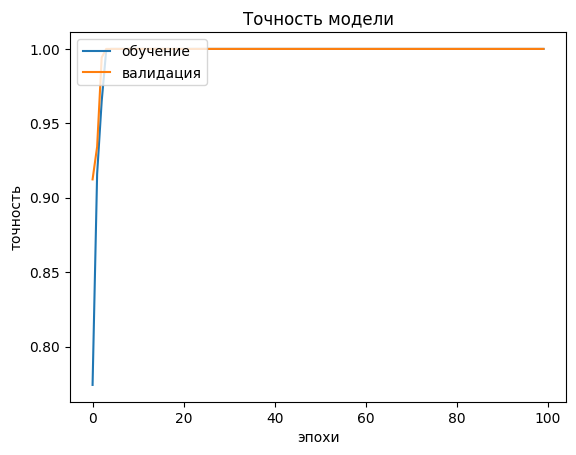

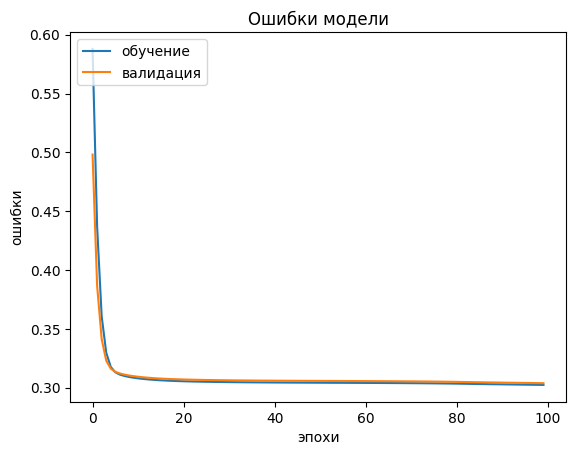

In [56]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('эпохи')
plt.legend(['обучение', 'валидация'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Ошибки модели')
plt.ylabel('ошибки')
plt.xlabel('эпохи')
plt.legend(['обучение', 'валидация'], loc='upper left')
plt.show()

In [60]:
month = 10
day = 1
test_data, test_result = generator.generate(10, 1)
print(test_data)
print(test_result)

predict = model.predict(
    np.array([
        np.array([month, day] + test_data)
    ])
)
print(predict)

[50, 3, 81]
[0, 32, 1]
1/1 [==============================] - 0s 79ms/step
[[3.2310454e-30 1.0000000e+00 0.0000000e+00]]


In [30]:

class BuyFrontierPredict:
    def __init__(self, base_year: int):
        self.base_year = base_year
        self.date_predict = {}
        self.year_range = self.get_year_range(base_year)

    @staticmethod
    def get_year_range(base_year):
        date_current = date(base_year, 1, 1)
        date_end = date(base_year + 1, 1, 1)

        year_range = []
        while date_current < date_end:
            year_range.append(date_current)
            date_current += timedelta(days=1)

        return year_range

    def get_date(self, month, day) -> date:
        return date(self.base_year, month, day)

    def fit(self, data: [(list, list)]):
        for index, ((month, day, *storage), buy_info) in enumerate(data):
            (prev_month, prev_day, *prev_storage) = data[index - 1][0]

            buy_frontiers = [
                (prev_storage[index] + storage[index]) / 2
                if (buy != 0) and (prev_storage[index] > storage[index])
                else 0
                for index, buy in enumerate(buy_info)
            ]

            current_date = self.get_date(month, day)
            if current_date in self.date_predict.keys():
                predict = self.date_predict[current_date]
                for index, buy_frontier in enumerate(buy_frontiers):
                    if buy_frontier:
                        if predict[index]:
                            predict[index] = (predict[index] + buy_frontier ) / 2
                        else:
                            predict[index] = buy_frontier
            else:
                self.date_predict[current_date] = buy_frontiers

    def periodic_average_frontier(self, period_day: int):
        period_counter = 0
        periodic_average = []
        for current_date in self.year_range:
            current_data = self.date_predict.get(current_date)
            if not period_counter:
                periodic_average.append({
                    'date': current_date,
                    'data': current_data
                })
            else:
                last_data = periodic_average[-1]['data']
                periodic_average[-1]['data'] = [
                    position + current_data[index]
                    for index, position in enumerate(last_data)
                ]
                if period_counter == period_day:
                    periodic_average[-1]['data'] = [
                        position / period_day
                        for position in periodic_average[-1]['data']
                    ]
                    period_counter = 0
                    periodic_average.append({
                    'date': current_date,
                    'data': current_data
                })

            period_counter += 1
        periodic_average[-1]['data'] = [
                        position / period_day
                        for position in periodic_average[-1]['data']
                    ]
        return periodic_average



In [31]:
predictor = BuyFrontierPredict(2022)

In [32]:
predictor.fit(data)

In [41]:
periods_data = predictor.periodic_average_frontier(10)

[(datetime.date(2022, 1, 1), [49.5, 34.5, 43.15325626779041]), (datetime.date(2022, 1, 11), [54.45, 37.95, 41.098018517141796]), (datetime.date(2022, 1, 21), [54.45, 37.95, 40.23073882177006]), (datetime.date(2022, 1, 31), [54.45, 37.95, 39.979015503773475]), (datetime.date(2022, 2, 10), [54.45, 37.95, 38.16003590356719]), (datetime.date(2022, 2, 20), [54.27449958638065, 37.19836602328738, 36.377573810659555]), (datetime.date(2022, 3, 2), [50.931484291987964, 18.231622266620825, 78.16222530175288]), (datetime.date(2022, 3, 12), [50.61757092673953, 17.329209325004935, 85.94893061614647]), (datetime.date(2022, 3, 22), [50.62658569071918, 17.70660358333555, 85.76124695603232]), (datetime.date(2022, 4, 1), [50.477902114130345, 17.52903135157087, 85.16049316120822]), (datetime.date(2022, 4, 11), [50.68629473827635, 17.26557135375149, 85.6834312052492]), (datetime.date(2022, 4, 21), [50.734591603732625, 17.38641232236558, 85.99042802665515]), (datetime.date(2022, 5, 1), [50.60556531395659, 1

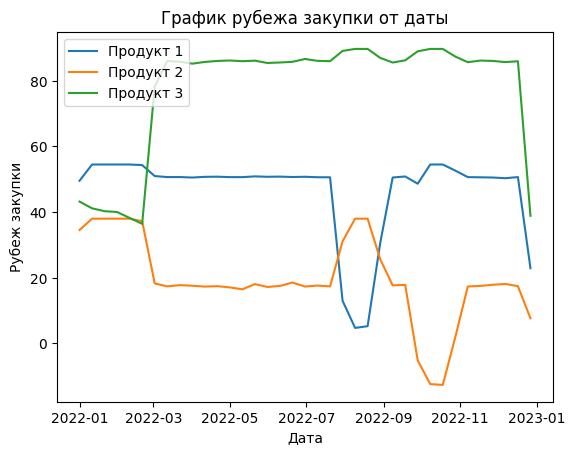

In [42]:
import matplotlib.pyplot as plt

plot_data = [
    (period['date'], period['data'])
    for period in periods_data
]
def get_chart_x():
    return [
        name
        for name, data in plot_data
    ]
chart_x = get_chart_x()

def get_chart_y(position_index: int):
    return [
        data[position_index]
        for name, data in plot_data
    ]
chart_y1 = get_chart_y(0)
chart_y2 = get_chart_y(1)
chart_y3 = get_chart_y(2)

plt.plot(chart_x, chart_y1)
plt.plot(chart_x, chart_y2)
plt.plot(chart_x, chart_y3)
plt.title('График рубежа закупки от даты')
plt.ylabel('Рубеж закупки')
plt.xlabel('Дата')
plt.legend(['Продукт 1', 'Продукт 2', 'Продукт 3'], loc='upper left')
plt.show()